# Sebastian Petrik - Stranasum - Visualization module

In [1]:
%pip install contractions --quiet

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import contractions

2023-05-17 13:42:23.403440: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 13:42:23.882648: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-17 13:42:23.882693: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-17 13:42:23.882698: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [35]:
class TextProcessor:
    
    # Text cleanup
    def clean_text(self, text: str):

        # lowercase
        text = str(text).lower()

        # remove &-escaped characters
        text = re.sub(r"&.[1-9]+;"," ", str(text))

        # remove escaped characters
        text=re.sub("(\\t)", ' ', str(text))
        text=re.sub("(\\r)", ' ', str(text))
        text=re.sub("(\\n)", ' ', str(text))

        # remove double characters
        text=re.sub("(__+)", ' ', str(text))  #remove _ if it occurs more than one time consecutively
        text=re.sub("(--+)", ' ', str(text))   #remove - if it occurs more than one time consecutively
        text=re.sub("(~~+)", ' ', str(text))   #remove ~ if it occurs more than one time consecutively
        text=re.sub("(\+\++)", ' ', str(text))  #remove + if it occurs more than one time consecutively
        text=re.sub("(\.\.+)", ' ', str(text))  #remove . if it occurs more than one time consecutively
        
        # special - fix u.s. contraction in gigaword
        text = re.sub("(u\.s\.)", 'united states', str(text))
        
        # fix contractions to base form
        text = contractions.fix(text)

        #remove special tokens <>()|&©ø"',;?~*!
        text=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower()

        # CNN mail data cleanup
        text=re.sub("(mailto:)", ' ', str(text)) #remove mailto:
        text=re.sub(r"(\\x9\d)", ' ', str(text)) #remove \x9* in text
        text=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(text)) #replace INC nums to INC_NUM
        text=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(text)) #replace CM# and CHG# to CM_NUM

        # url replacement into base form
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(text))
            repl_url = url.group(3)
            text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(text))
        except:
            pass


        # handle dot at the end of words
        text=re.sub("(\.\s+)", ' ', str(text)) # remove
        
        text=re.sub("(\-\s+)", ' ', str(text)) #remove - at end of words(not between)
        text=re.sub("(\:\s+)", ' ', str(text)) #remove : at end of words(not between)

        #remove multiple spaces
        text=re.sub("(\s+)",' ',str(text))

        # apply lowercase again
        text = text.lower().strip()
        
        # remove trailing dot, we will apply end of sequence anyway
        text = re.sub("(\.)$", '', str(text)).strip()
        
        # gigaword - UNK token
        text = re.sub("unk", '', str(text).strip())
        
        # gigaword - change numbers to hashtags
        text = re.sub("\d", "#", str(text).strip())

        return text

    def apply_special_tokens(self, text):
        text = str(text).strip()
        text = "<sos> " + str(text).strip() + " <eos>"
        return text

    def remove_special_tokens(self, text):
        text = text.lower()
        text = text.replace("<sos>", "").replace("<eos>", "")
        text = text.strip()
        return text

class Summarizer:
    
    # Initialize using SummarizationModule or loaded graph tf module
    def __init__(self, module: tf.Module):
        self.module = module
        self.processor = TextProcessor()
        
    def summarize(self, text: str):
        prepared = self.processor.apply_special_tokens(self.processor.clean_text(text))
        output_text, output_tensor, weights = self.module.predict(tf.constant([prepared]))
        return prepared, self.processor.remove_special_tokens(bytes.decode(output_text.numpy())), output_tensor, weights
    
    # Shorthand for text output only
    def __call__(self, text: str):
        return self.summarize(text)[1]
    
module = tf.saved_model.load("./summarizer_module")
summarizer = Summarizer(module)

In [221]:
euro = """european union leaders gave slovenia a green light friday to join the eurozone next year , launching a new wave of expansion for the currently ##-nation single currency club ."""
afgan = "journalists and legislators in afghanistan have been outraged by the intelligence service 's new media guidelines that bar interviews with taliban leaders and criticism of foreign troops ."
gradu = "hundreds of graduates from america 's most prestigious universities are temporarily setting aside their high-powered career ambitions to teach at inner-city schools , as part of a program to help children from low-income families ."
fires = "estonians will miss their traditional midsummer bonfires in state-owned forests this year after the authorities on tuesday banned the practice because of risk of forest fires ."

article = fires
prepared, summary, output, attention_weights = summarizer.summarize(article)
summary

'estonia bans forest fires'

In [165]:
prepared

'<sos> journalists and legislators in afghanistan have been outraged by the intelligence service s new media guidelines that bar interviews with taliban leaders and criticism of foreign troops <eos>'

In [129]:
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.


# example
# attention = attention_heads[0]
# attention.shape

In [130]:
# attention_heads[0][1, :(article_l)]

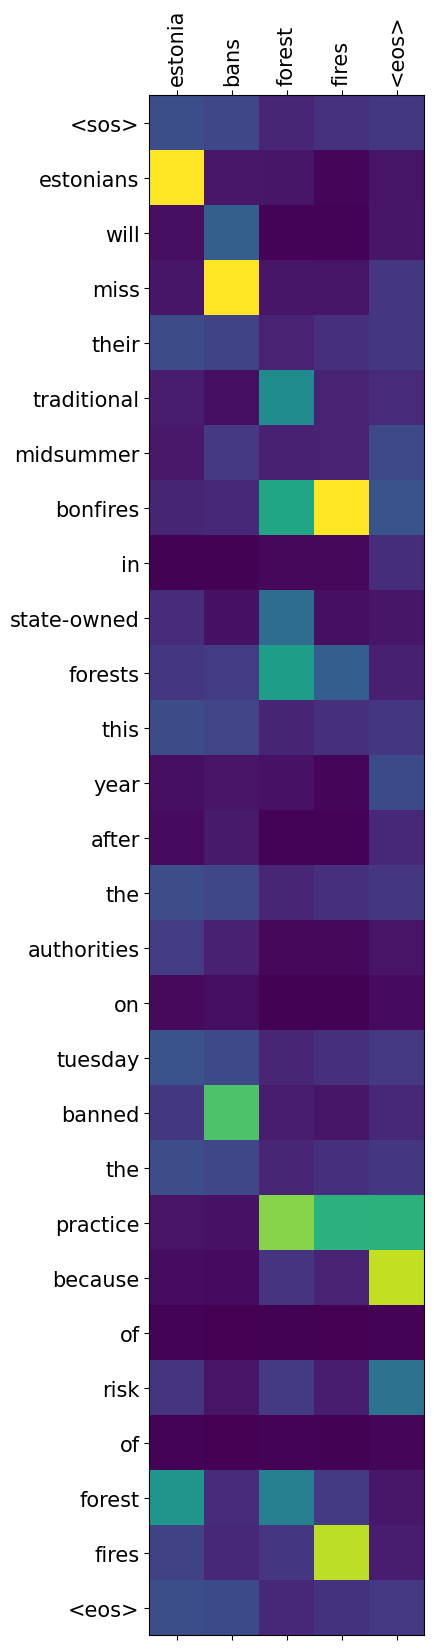

In [222]:
# aggregated attention for all heads
def extract_agg_attention(weights, article_len):
    
    attention_heads = tf.squeeze(attention_weights, 0)
    attention = sum(attention_heads)[:, :(article_len)] # restrict by article len
    
    # custom clipping and scaling for visualisation
    attention = tf.clip_by_value(
        attention,
        clip_value_min=0,
        clip_value_max=1.6
    )
    
    attention = (attention) / tf.reduce_max(attention)
    
    return attention

def plot_attention_head(article_tok, sum_tok, attention):
    # The model didn't generate `<START>` in the output. Skip it.
    sum_tok_reduced = sum_tok[1:]

    ax = plt.gca()
    ax.matshow(tf.transpose(attention))
    ax.set_yticks(range(len(article_tok)))
    ax.set_xticks(range(len(sum_tok_reduced)))

    # labels = [label.decode('utf-8') for label in in_tokens.numpy()]
    ax.set_yticklabels(article_tok)

    # labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
    ax.set_xticklabels(sum_tok_reduced, rotation=90)
    
def plot_agg_attention(article_tok, sum_tok, attention_weights):
    plt.rcParams['figure.figsize'] = [20, 20]
    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick', labelsize=15) 
    plot_attention_head(
        article_tok,
        sum_tok,
        extract_agg_attention(attention_weights, len(article_tok))
    )
    
    
article_tok = prepared.split(" ")
sum_tok = ['<sos>'] + summary.split(" ") + ['<eos>'] # add back the tokens

# plot_attention_head(article_tok, sum_tok, attention[:, :(article_l)])
plot_agg_attention(article_tok, sum_tok, attention_weights)